## Break Time and Performance

Here we analyse the average performance of greyhounds (using their SpeedNorm) as a function of Break Time (number of days since their last race). 

We find that the most optimal amount of time between races is approximately 7 days, and as we deviate from this time the performance begins to decrease. We also find that greyhounds tend to perform below the mean if the Break Time is 4 days or less, and 11 days or more.

----

### 0. Read cleansed data

In [1]:
import os
import decouple
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as plticker

from scipy.stats import zscore

config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
sys.path.insert(0, '')

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')
df_raw['RaceDate'] = pd.to_datetime(df_raw['RaceDate'], format='%Y-%m-%d')

display(df_raw.head())

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01


### 1. Analysis

,BreakTime,SpeedNorm_mean,SpeedNorm_std,SampleSize
5,3 or Less,-0.092641,0.979856,56916
6,4.0,-0.023488,0.966197,67371
7,5.0,0.030480,0.976722,57817
8,6.0,0.049345,0.983878,50824
9,7.0,0.075904,0.968758,233590
10,8.0,0.040166,0.990229,36499
11,9.0,0.018692,1.000312,29283
0,10.0,0.008327,0.999447,24872
1,11.0,-0.012226,0.999189,17477
2,12.0,-0.052755,1.042290,10628


<AxesSubplot:xlabel='BreakTime', ylabel='SpeedNorm_mean'>

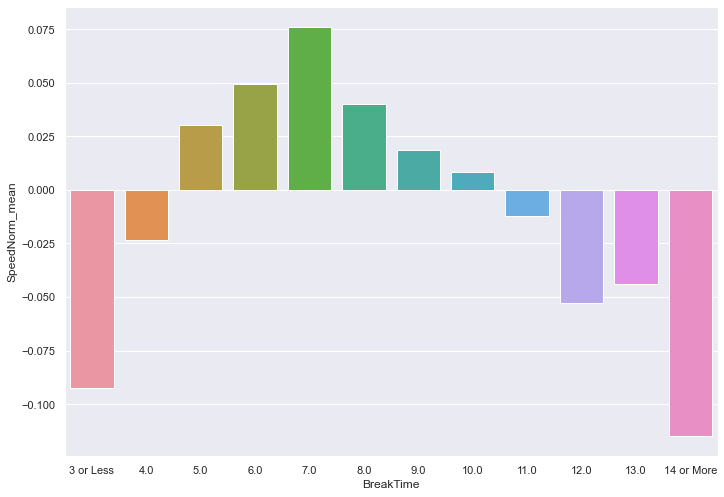

In [20]:
# Copy
df = df_raw.copy()

# remove NaN tracks
df = df[~df.TrackDist.isna()]

# Create BreakTime column (number of days between each race)
df = df.sort_values(by=['FasttrackDogId', 'RaceDate'], ascending=True)
def breaktime_func(day_int):
    '''
    Converts BreakTime to a string
    '''
    if day_int <= 3:
        return '3 or Less'
    elif day_int >= 14:
        return '14 or More'
    else:
        return str(day_int)
df['BreakTime'] = df.groupby('FasttrackDogId')['RaceDate'].transform(lambda x: x.diff().dt.days)
df = df[~df['BreakTime'].isna()]
df['BreakTime'] = df['BreakTime'].apply(lambda x: breaktime_func(x))

# Create SpeedNorm column
df["Speed"] = df["Distance"]/df["RunTime"]
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Drop NaN columns
df = df[['BreakTime', 'SpeedNorm']]

# Groupby BreakTime and calculate statistics
df = df.groupby('BreakTime', as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                SpeedNorm_std=('SpeedNorm', 'std'),
                                                SampleSize=('SpeedNorm', 'count'))

df = df.reindex([5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4])

display(df)

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(11.7, 8.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
sns.barplot(data=df, x="BreakTime", y="SpeedNorm_mean")